In [1]:
import os
import json

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(0)

from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from livelossplot import PlotLosses

import ternausnet.models
model = ternausnet.models.UNet11(pretrained=True)

In [2]:
root_path = 'datasets/landcover_processed/rotated_crops/'
list_dataset = os.listdir(root_path)
list_dataset = list(map(lambda x: root_path + x, list_dataset))
train_img_list, test_img_list = train_test_split(list_dataset, test_size=0.15)
test_img_list = list(filter(lambda x: x.endswith('-0.png'), test_img_list))

In [3]:
print(len(train_img_list), len(test_img_list))
with open('train_img_list.json', 'w') as f:
    json.dump(train_img_list, f)
    
with open('test_img_list.json', 'w') as f:
    json.dump(test_img_list, f)

23210 983


In [4]:
from lib.train import WaterDataset, viz, train_transform, test_transform

In [5]:
d_train = WaterDataset('train_img_list.json', train_transform)
d_val = WaterDataset('test_img_list.json', test_transform)

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [30]:
def viz2(s):
    img = (s * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None,None])
    print(img.min(), img.max())
    img = (255 * img).transpose(0,1).transpose(1,2).numpy().astype(np.uint8)
    plt.imshow(img)

tensor(0.) tensor(0.6275)


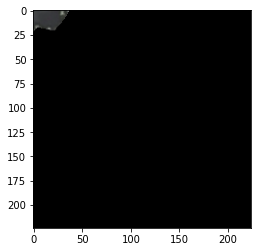

In [31]:
viz2(d_val[3][0])

In [14]:
d_val[3]

(tensor([[[-0.9877, -0.9705, -0.9705,  ..., -2.1179, -2.1179, -2.1179],
          [-0.9877, -0.9705, -0.9705,  ..., -2.1179, -2.1179, -2.1179],
          [-1.0048, -0.9705, -0.9705,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-0.8102, -0.8277, -0.8452,  ..., -2.0357, -2.0357, -2.0357],
          [-0.7927, -0.8277, -0.8277,  ..., -2.0357, -2.0357, -2.0357],
          [-0.8102, -0.8102, -0.8277,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-0.5670, -0.5670, -0.5844,  ..., -1.8044, -1.8044, -1.8044],
          [-0.5670, -0.5670,

In [ ]:
loss = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters())

dl_train = DataLoader(d_train, batch_size=4, shuffle=True, num_workers=4)

dl_val = DataLoader(d_val, batch_size=4, shuffle=False, num_workers=4)

num_epochs = 100

device = 'cuda:0'

model = model.to(device)

groups = {'acccuracy': ['acc', 'val_acc'], 'bce-loss': ['loss', 'val_loss'], 'lake-acc': ['lakeacc', 'val_lakeacc']}

plotlosses = PlotLosses(groups=groups)

topk_val_losses = {}

train_id = '123'

for epoch in range(num_epochs):
    print('train step')
    
    S_loss = 0
    S_accuracy = 0
    S_lake_accuracy = 0
    for idx, (im, gt) in enumerate(dl_train):
        im = im.to(device)
        gt = gt.to(device)
        optimizer.zero_grad()
        
        pred = model(im)
        L = loss(pred, gt)
        assert pred.shape == gt.shape
        treshold = 0.5
        accuracy = ((pred > threshold) != gt.bool()).sum().item() / pred.numel()
        lake_accuracy = ((gt == 1) & (pred > threshold)).sum().item() / (gt == 1).sum().item()
        #(pred[[]] - gt
        # print(L.item())
              #(pred > 0.5).sum())
        S_loss += L.item()
        S_accuracy += accuracy
        S_lake_accuracy += lake_accuracy
        L.backward()
        optimizer.step()
    train_loss = S_loss / (idx + 1)
    train_accuracy = S_accuracy/ (idx + 1)
    train_lake_accuracy = S_lake_accuracy/ (idx + 1)
    
        #if (idx % 10) == 0:
        #    pass # eval
        
    print('eval step')
    S_loss = 0
    S_accuracy = 0
    S_lake_accuracy = 0
    for idx, (im, gt) in enumerate(dl_val):
        im = im.to(device)
        gt = gt.to(device)
        pred = model(im)
        L = loss(pred, gt)
        # print(L.item())
        S_loss += L.item()
        treshold = 0.5
        accuracy = ((pred > threshold) != gt.bool()).sum().item() / pred.numel()
        lake_accuracy = ((gt == 1) & (pred > threshold)).sum().item() / (gt == 1).sum().item()
        S_accuracy += accuracy
        S_lake_accuracy += lake_accuracy
    val_loss = S_loss / (idx + 1)
    val_accuracy = S_accuracy/ (idx + 1)
    val_lake_accuracy = S_lake_accuracy/ (idx + 1)
    
    plotlosses.update({'val_loss': val_loss, 'loss': train_loss, 'val_acc': val_accuracy, 'acc': train_accuracy, 'lakeacc': train_lake_accuracy, 'val_lakeacc': val_lake_accuracy})
    plotlosses.send()
    
    if (len(topk_val_losses) < 5) or (val_loss < max(topk_val_losses.keys())):
        if (len(topk_val_losses) > 0) and (val_loss < max(topk_val_losses.keys())):
            argmin = max(topk_val_losses.keys())
            fname = topk_val_losses[argmin]
            os.remove(fname)
            del topk_val_losses[argmin]
        topk_val_losses[val_loss] = f'model-{train_id}-{epoch}.pth'
        torch.save(model.state_dict(), f'model-{train_id}-{epoch}.pth')
        
torch.save(model.state_dict(), 'model-latest.pth')